**Executed:** Sat Mar 25 23:35:50 2017

**Duration:** 9 seconds.

# usALEX-5samples - Template

> *This notebook is executed through [8-spots paper analysis](8-spots paper analysis.ipynb).*
> *For a direct execution, uncomment the cell below.*

In [1]:
ph_sel_name = "AexAem"

In [2]:
data_id = "12d"

In [3]:
# ph_sel_name = "all-ph"
# data_id = "7d"

## Load software and filenames definitions

In [4]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.9).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [5]:
init_notebook()
from IPython.display import display

Data folder:

In [6]:
data_dir = './data/singlespot/'

Check that the folder exists:

In [7]:
import os
data_dir = os.path.abspath(data_dir) + '/'
assert os.path.exists(data_dir), "Path '%s' does not exist." % data_dir

List of data files in `data_dir`:

In [8]:
from glob import glob

In [9]:
file_list = sorted(f for f in glob(data_dir + '*.hdf5') if '_BKG' not in f)
file_list

['/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/004_dsDNA_17d_green100u_red40u.hdf5',
 '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/005_dsDNA_27d_green100u_red40u.hdf5',
 '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/006_dsDNA_7d_green100u_red40u.hdf5',
 '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/007_dsDNA_12d_3nM_green100u_red40u.hdf5',
 '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/008_dsDNA_22d_500pM_green100u_red40u.hdf5',
 '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/2012-12-06_001_4 Channel Dark Count.hdf5']

In [10]:
## Selection for POLIMI 2012-12-6 dataset
# file_list.pop(2)
# file_list = file_list[1:-2]
# display(file_list)
# labels = ['22d', '27d', '17d', '12d', '7d']

In [11]:
## Selection for P.E. 2012-12-6 dataset
# file_list.pop(1)
# file_list = file_list[:-1]
# display(file_list)
# labels = ['22d', '27d', '17d', '12d', '7d']

In [12]:
## Selection for POLIMI 2012-11-26 datatset
labels = ['17d', '27d', '7d', '12d', '22d']

In [13]:
files_dict = {lab: fname for lab, fname in zip(labels, file_list)}
files_dict

{'12d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/007_dsDNA_12d_3nM_green100u_red40u.hdf5',
 '17d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/004_dsDNA_17d_green100u_red40u.hdf5',
 '22d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/008_dsDNA_22d_500pM_green100u_red40u.hdf5',
 '27d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/005_dsDNA_27d_green100u_red40u.hdf5',
 '7d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/006_dsDNA_7d_green100u_red40u.hdf5'}

In [14]:
ph_sel_map = {'all-ph': Ph_sel('all'), 'AexAem': Ph_sel(Aex='Aem')}
ph_sel = ph_sel_map[ph_sel_name]

data_id, ph_sel_name

('12d', 'AexAem')

## Data load

Initial loading of the data:

In [15]:
d = loader.photon_hdf5(filename=files_dict[data_id])

## Laser alternation selection

At this point we have only the timestamps and the detector numbers:

In [16]:
d.ph_times_t, d.det_t

([array([      42190,       56253,       56263, ..., 47999942928,
         47999959323, 48000016759])],
 [array([1, 0, 0, ..., 1, 1, 1], dtype=uint32)])

We need to define some parameters: donor and acceptor ch, excitation period and donor and acceptor excitiations:

In [17]:
d.add(det_donor_accept=(0, 1), alex_period=4000, D_ON=(2850, 580), A_ON=(900, 2580), offset=0)

We should check if everithing is OK with an alternation histogram:

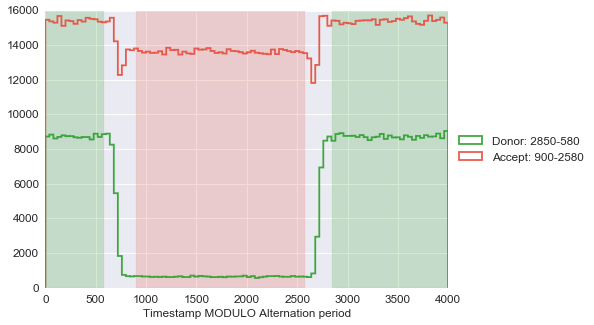

In [18]:
plot_alternation_hist(d)

If the plot looks good we can apply the parameters with:

In [19]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):   1,642,933
#  D  photons in D+A excitation periods:    404,153
#  A  photons in D+A excitation periods:  1,238,780
# D+A photons in  D  excitation period:   1,043,678
# D+A photons in  A  excitation period:     599,255



## Measurements infos

All the measurement data is in the `d` variable. We can print it:

In [20]:
d

singlespot_007_dsDNA_12d_3nM_green100u_red40u G1.000

Or check the **measurements duration**:

In [21]:
d.time_max

599.99949153749992

## Compute background

Compute the background using automatic threshold:

In [22]:
d.calc_bg(bg.exp_fit, time_s=60, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... 

[DONE]


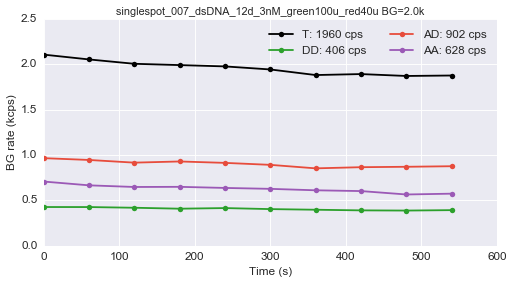

In [23]:
dplot(d, timetrace_bg)

In [24]:
d.rate_m, d.rate_dd, d.rate_ad, d.rate_aa

([1960.0483965382143],
 [406.04619715470801],
 [902.31032918273252],
 [628.25703861394027])

# Burst search and selection

In [25]:
from mpl_toolkits.axes_grid1 import AxesGrid
import lmfit
print('lmfit version:', lmfit.__version__)

lmfit version: 0.9.5


In [26]:
assert d.dir_ex == 0
assert d.leakage == 0

In [27]:
d.burst_search(m=10, F=6, ph_sel=ph_sel)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for AexAem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


In [28]:
print(d.ph_sel, d.num_bursts)

AexAem [7025]


In [29]:
ds_sa = d.select_bursts(select_bursts.naa, th1=30)
ds_sa.num_bursts

array([1771])

# Preliminary selection and plots

In [30]:
mask = (d.naa[0] - np.abs(d.na[0] + d.nd[0])) > 30
ds_saw = d.select_bursts_mask_apply([mask])

ds_sas0 = ds_sa.select_bursts(select_bursts.S, S2=0.10)
ds_sas = ds_sa.select_bursts(select_bursts.S, S2=0.15)
ds_sas2 = ds_sa.select_bursts(select_bursts.S, S2=0.20)
ds_sas3 = ds_sa.select_bursts(select_bursts.S, S2=0.25)

ds_st = d.select_bursts(select_bursts.size, add_naa=True, th1=30)
ds_sas.num_bursts

array([269])

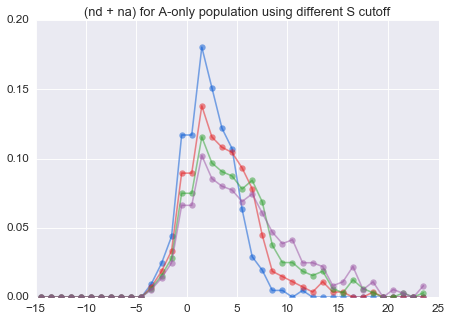

In [31]:
dx = ds_sas0
size = dx.na[0] + dx.nd[0]
s_hist, s_bins = np.histogram(size, bins=np.r_[-15 : 25 : 1], density=True)
s_ax = s_bins[:-1] + 0.5*(s_bins[1] - s_bins[0])
plot(s_ax, s_hist, '-o', alpha=0.5)

dx = ds_sas
size = dx.na[0] + dx.nd[0]
s_hist, s_bins = np.histogram(size, bins=np.r_[-15 : 25 : 1], density=True)
s_ax = s_bins[:-1] + 0.5*(s_bins[1] - s_bins[0])
plot(s_ax, s_hist, '-o', alpha=0.5)

dx = ds_sas2
size = dx.na[0] + dx.nd[0]
s_hist, s_bins = np.histogram(size, bins=np.r_[-15 : 25 : 1], density=True)
s_ax = s_bins[:-1] + 0.5*(s_bins[1] - s_bins[0])
plot(s_ax, s_hist, '-o', alpha=0.5)

dx = ds_sas3
size = dx.na[0] + dx.nd[0]
s_hist, s_bins = np.histogram(size, bins=np.r_[-15 : 25 : 1], density=True)
s_ax = s_bins[:-1] + 0.5*(s_bins[1] - s_bins[0])
plot(s_ax, s_hist, '-o', alpha=0.5)

plt.title('(nd + na) for A-only population using different S cutoff');

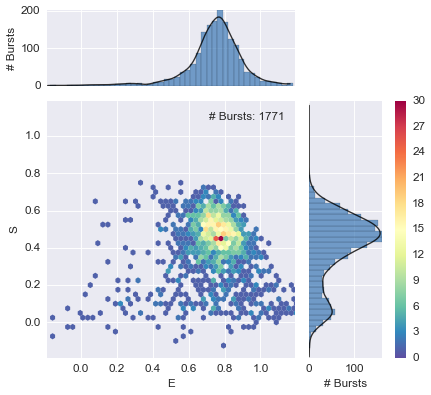

In [32]:
dx = ds_sa

alex_jointplot(dx);

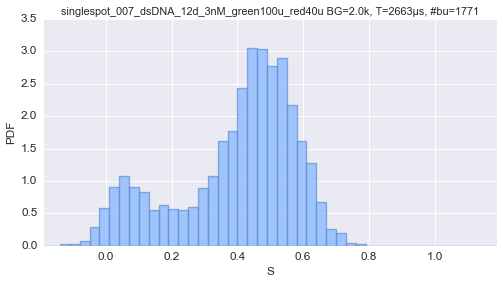

In [33]:
dplot(ds_sa, hist_S)

# A-direct excitation fitting

To extract the A-direct excitation coefficient we need to fit the 
S values for the A-only population.

The S value for the A-only population is fitted with different methods:
- Histogram git with 2 Gaussians or with 2 asymmetric Gaussians 
(an asymmetric Gaussian has right- and left-side of the peak
decreasing according to different sigmas).
- KDE maximum

In the following we apply these methods using different selection
or weighting schemes to reduce amount of FRET population and make
fitting of the A-only population easier.

## Even selection

Here A-only and FRET population are evenly selected.

In [34]:
dx = ds_sa

bin_width = 0.03
bandwidth = 0.03
bins = np.r_[-0.2 : 1 : bin_width]
x_kde = np.arange(bins.min(), bins.max(), 0.0002)

In [35]:
## Weights
weights = None

## Histogram fit
fitter_g = mfit.MultiFitter(dx.S)
fitter_g.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter_g.fit_histogram(model = mfit.factory_two_gaussians(p1_center=0.1, p2_center=0.4))
S_hist_orig = fitter_g.hist_pdf

S_2peaks = fitter_g.params.loc[0, 'p1_center']
dir_ex_S2p = S_2peaks/(1 - S_2peaks)
print('Fitted direct excitation (na/naa) [2-Gauss]:', dir_ex_S2p)

## KDE
fitter_g.calc_kde(bandwidth=bandwidth)
fitter_g.find_kde_max(x_kde, xmin=0, xmax=0.15)

S_peak = fitter_g.kde_max_pos[0]
dir_ex_S_kde = S_peak/(1 - S_peak)
print('Fitted direct excitation (na/naa) [KDE]:    ', dir_ex_S_kde)

Fitted direct excitation (na/naa) [2-Gauss]: 0.09247943018227554
Fitted direct excitation (na/naa) [KDE]:     0.0604453870626


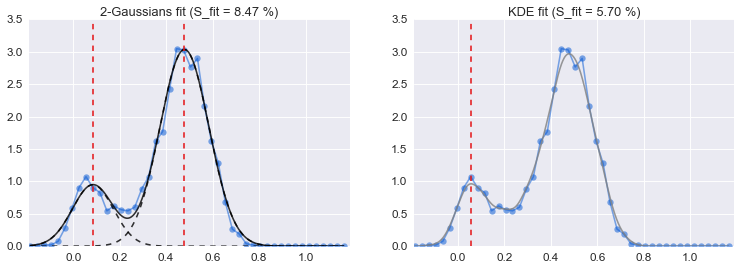

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))

mfit.plot_mfit(fitter_g, ax=ax[0])
ax[0].set_title('2-Gaussians fit (S_fit = %.2f %%)' % (S_2peaks*100))

mfit.plot_mfit(fitter_g, ax=ax[1], plot_model=False, plot_kde=True)
ax[1].set_title('KDE fit (S_fit = %.2f %%)' % (S_peak*100));

In [37]:
## 2-Asym-Gaussian
fitter_ag = mfit.MultiFitter(dx.S)
fitter_ag.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter_ag.fit_histogram(model = mfit.factory_two_asym_gaussians(p1_center=0.1, p2_center=0.4))
#print(fitter_ag.fit_obj[0].model.fit_report())

S_2peaks_a = fitter_ag.params.loc[0, 'p1_center']
dir_ex_S2pa = S_2peaks_a/(1 - S_2peaks_a)
print('Fitted direct excitation (na/naa) [2-Gauss]:', dir_ex_S2pa)

Fitted direct excitation (na/naa) [2-Gauss]: 0.041669950450563424


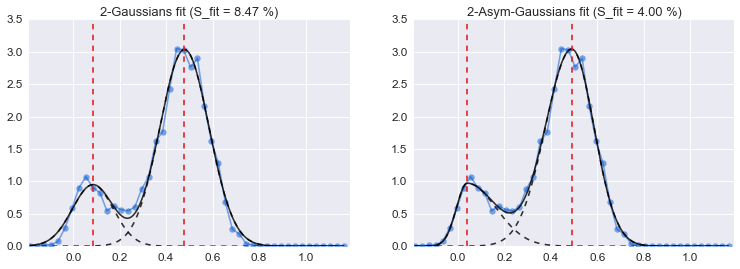

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))

mfit.plot_mfit(fitter_g, ax=ax[0])
ax[0].set_title('2-Gaussians fit (S_fit = %.2f %%)' % (S_2peaks*100))

mfit.plot_mfit(fitter_ag, ax=ax[1])
ax[1].set_title('2-Asym-Gaussians fit (S_fit = %.2f %%)' % (S_2peaks_a*100));

## Zero threshold on nd

Select bursts with:

$$n_d < 0$$.

In [39]:
dx = ds_sa.select_bursts(select_bursts.nd, th1=-100, th2=0)

fitter = bext.bursts_fitter(dx, 'S')
fitter.fit_histogram(model = mfit.factory_gaussian(center=0.1))
S_1peaks_th = fitter.params.loc[0, 'center']
dir_ex_S1p = S_1peaks_th/(1 - S_1peaks_th)
print('Fitted direct excitation (na/naa) [2-Gauss]:', dir_ex_S1p)

Fitted direct excitation (na/naa) [2-Gauss]: 0.03709999457979202


(-0.1, 0.6)

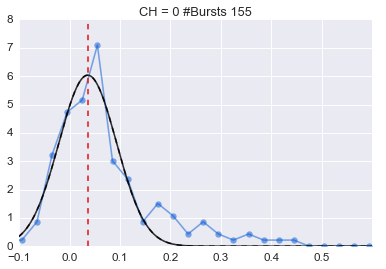

In [40]:
mfit.plot_mfit(fitter)
plt.xlim(-0.1, 0.6)

## Selection 1

Bursts are weighted using $w = f(S)$, where the function $f(S)$ is a
Gaussian fitted to the $S$ histogram of the FRET population.

In [41]:
dx = ds_sa

## Weights
weights = 1 - mfit.gaussian(dx.S[0], fitter_g.params.loc[0, 'p2_center'], fitter_g.params.loc[0, 'p2_sigma'])
weights[dx.S[0] >= fitter_g.params.loc[0, 'p2_center']] = 0

## Histogram fit
fitter_w1 = mfit.MultiFitter(dx.S)
fitter_w1.weights = [weights]
fitter_w1.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter_w1.fit_histogram(model = mfit.factory_two_gaussians(p1_center=0.1, p2_center=0.4))
S_2peaks_w1 = fitter_w1.params.loc[0, 'p1_center']
dir_ex_S2p_w1 = S_2peaks_w1/(1 - S_2peaks_w1)
print('Fitted direct excitation (na/naa) [2-Gauss]:', dir_ex_S2p_w1)

## KDE
fitter_w1.calc_kde(bandwidth=bandwidth)
fitter_w1.find_kde_max(x_kde, xmin=0, xmax=0.15)
S_peak_w1 = fitter_w1.kde_max_pos[0]
dir_ex_S_kde_w1 = S_peak_w1/(1 - S_peak_w1)
print('Fitted direct excitation (na/naa) [KDE]:    ', dir_ex_S_kde_w1)

Fitted direct excitation (na/naa) [2-Gauss]: 0.07357530993043108


Fitted direct excitation (na/naa) [KDE]:     0.0604453870626


In [42]:
def plot_weights(x, weights, ax):
    ax2 = ax.twinx()
    x_sort = x.argsort()
    ax2.plot(x[x_sort], weights[x_sort], color='k', lw=4, alpha=0.4)
    ax2.set_ylabel('Weights');

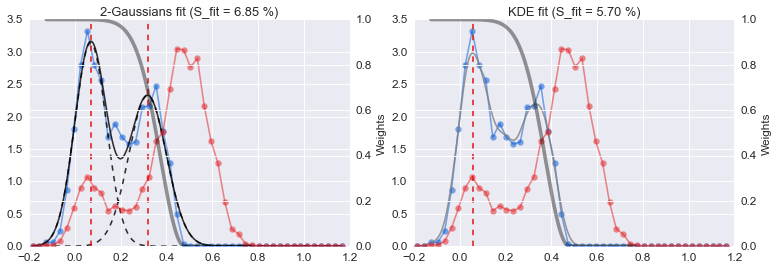

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))
mfit.plot_mfit(fitter_w1, ax=ax[0])
mfit.plot_mfit(fitter_g, ax=ax[0], plot_model=False, plot_kde=False)
plot_weights(dx.S[0], weights, ax=ax[0])
ax[0].set_title('2-Gaussians fit (S_fit = %.2f %%)' % (S_2peaks_w1*100))

mfit.plot_mfit(fitter_w1, ax=ax[1], plot_model=False, plot_kde=True)
mfit.plot_mfit(fitter_g, ax=ax[1], plot_model=False, plot_kde=False)
plot_weights(dx.S[0], weights, ax=ax[1])
ax[1].set_title('KDE fit (S_fit = %.2f %%)' % (S_peak_w1*100));

## Selection 2

Bursts are here weighted using weights $w$:

$$w = n_{aa} - |n_a + n_d|$$

In [44]:
## Weights
sizes = dx.nd[0] + dx.na[0] #- dir_ex_S_kde_w3*dx.naa[0]
weights = dx.naa[0] - abs(sizes)
weights[weights < 0] = 0

## Histogram
fitter_w4 = mfit.MultiFitter(dx.S)
fitter_w4.weights = [weights]
fitter_w4.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter_w4.fit_histogram(model = mfit.factory_two_gaussians(p1_center=0.1, p2_center=0.4))
S_2peaks_w4 = fitter_w4.params.loc[0, 'p1_center']
dir_ex_S2p_w4 = S_2peaks_w4/(1 - S_2peaks_w4)
print('Fitted direct excitation (na/naa) [2-Gauss]:', dir_ex_S2p_w4)

## KDE
fitter_w4.calc_kde(bandwidth=bandwidth)
fitter_w4.find_kde_max(x_kde, xmin=0, xmax=0.15)
S_peak_w4 = fitter_w4.kde_max_pos[0]
dir_ex_S_kde_w4 = S_peak_w4/(1 - S_peak_w4)
print('Fitted direct excitation (na/naa) [KDE]:    ', dir_ex_S_kde_w4)

Fitted direct excitation (na/naa) [2-Gauss]: 0.07576608800831311
Fitted direct excitation (na/naa) [KDE]:     0.0570824524313


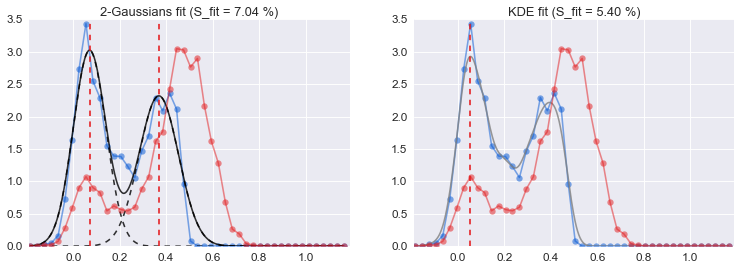

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))

mfit.plot_mfit(fitter_w4, ax=ax[0])
mfit.plot_mfit(fitter_g, ax=ax[0], plot_model=False, plot_kde=False)
#plot_weights(dx.S[0], weights, ax=ax[0])
ax[0].set_title('2-Gaussians fit (S_fit = %.2f %%)' % (S_2peaks_w4*100))

mfit.plot_mfit(fitter_w4, ax=ax[1], plot_model=False, plot_kde=True)
mfit.plot_mfit(fitter_g, ax=ax[1], plot_model=False, plot_kde=False)
#plot_weights(dx.S[0], weights, ax=ax[1])
ax[1].set_title('KDE fit (S_fit = %.2f %%)' % (S_peak_w4*100));

## Selection 3

Bursts are here selected according to:

$$n_{aa} - |n_a + n_d| > 30$$

In [46]:
mask = (d.naa[0] - np.abs(d.na[0] + d.nd[0])) > 30
ds_saw = d.select_bursts_mask_apply([mask])
print(ds_saw.num_bursts)

dx = ds_saw

## Weights
weights = None

## 2-Gaussians
fitter_w5 = mfit.MultiFitter(dx.S)
fitter_w5.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter_w5.fit_histogram(model = mfit.factory_two_gaussians(p1_center=0.1, p2_center=0.4))
S_2peaks_w5 = fitter_w5.params.loc[0, 'p1_center']
dir_ex_S2p_w5 = S_2peaks_w5/(1 - S_2peaks_w5)
print('Fitted direct excitation (na/naa) [2-Gauss]:', dir_ex_S2p_w5)

## KDE
fitter_w5.calc_kde(bandwidth=bandwidth)
fitter_w5.find_kde_max(x_kde, xmin=0, xmax=0.15)
S_peak_w5 = fitter_w5.kde_max_pos[0]
S_2peaks_w5_fiterr = fitter_w5.fit_res[0].params['p1_center'].stderr
dir_ex_S_kde_w5 = S_peak_w5/(1 - S_peak_w5)
print('Fitted direct excitation (na/naa) [KDE]:    ', dir_ex_S_kde_w5)

## 2-Asym-Gaussians
fitter_w5a = mfit.MultiFitter(dx.S)
fitter_w5a.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter_w5a.fit_histogram(model = mfit.factory_two_asym_gaussians(p1_center=0.05, p2_center=0.3))
S_2peaks_w5a = fitter_w5a.params.loc[0, 'p1_center']
dir_ex_S2p_w5a = S_2peaks_w5a/(1 - S_2peaks_w5a)
#print(fitter_w5a.fit_obj[0].model.fit_report(min_correl=0.5))
print('Fitted direct excitation (na/naa) [2-Asym-Gauss]:', dir_ex_S2p_w5a)

[384]
Fitted direct excitation (na/naa) [2-Gauss]: 0.057560479105294604
Fitted direct excitation (na/naa) [KDE]:     0.0548523206751
Fitted direct excitation (na/naa) [2-Asym-Gauss]: 0.044884148571452766


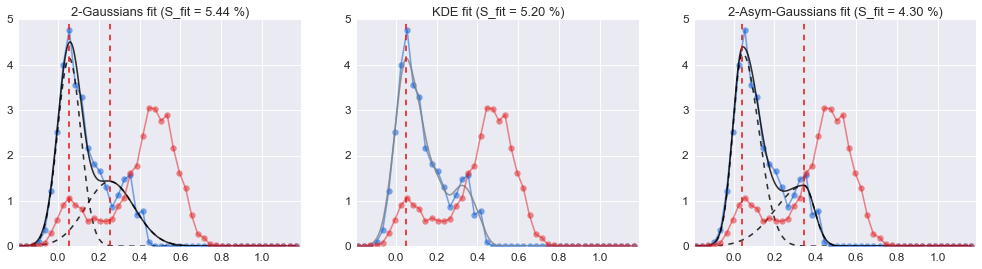

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(19, 4.5))

mfit.plot_mfit(fitter_w5, ax=ax[0])
mfit.plot_mfit(fitter_g, ax=ax[0], plot_model=False, plot_kde=False)
ax[0].set_title('2-Gaussians fit (S_fit = %.2f %%)' % (S_2peaks_w5*100))

mfit.plot_mfit(fitter_w5, ax=ax[1], plot_model=False, plot_kde=True)
mfit.plot_mfit(fitter_g, ax=ax[1], plot_model=False, plot_kde=False)
ax[1].set_title('KDE fit (S_fit = %.2f %%)' % (S_peak_w5*100));

mfit.plot_mfit(fitter_w5a, ax=ax[2])
mfit.plot_mfit(fitter_g, ax=ax[2], plot_model=False, plot_kde=False)
ax[2].set_title('2-Asym-Gaussians fit (S_fit = %.2f %%)' % (S_2peaks_w5a*100));

# Save data to file

In [48]:
sample = data_id
n_bursts_aa = ds_sas.num_bursts[0]

The following string contains the list of variables to be saved. When saving, the order of the variables is preserved.

In [49]:
variables = ('sample n_bursts_aa dir_ex_S1p dir_ex_S_kde dir_ex_S2p dir_ex_S2pa '
             'dir_ex_S2p_w1 dir_ex_S_kde_w1 dir_ex_S_kde_w4 dir_ex_S_kde_w5 dir_ex_S2p_w5 dir_ex_S2p_w5a '
             'S_2peaks_w5 S_2peaks_w5_fiterr\n')

This is just a trick to format the different variables:

In [50]:
variables_csv = variables.replace(' ', ',')
fmt_float = '{%s:.6f}'
fmt_int = '{%s:d}'
fmt_str = '{%s}'
fmt_dict = {**{'sample': fmt_str}, 
            **{k: fmt_int for k in variables.split() if k.startswith('n_bursts')}}
var_dict = {name: eval(name) for name in variables.split()}
var_fmt = ', '.join([fmt_dict.get(name, fmt_float) % name for name in variables.split()]) + '\n'
data_str = var_fmt.format(**var_dict)

print(variables_csv)
print(data_str)

sample,n_bursts_aa,dir_ex_S1p,dir_ex_S_kde,dir_ex_S2p,dir_ex_S2pa,dir_ex_S2p_w1,dir_ex_S_kde_w1,dir_ex_S_kde_w4,dir_ex_S_kde_w5,dir_ex_S2p_w5,dir_ex_S2p_w5a,S_2peaks_w5,S_2peaks_w5_fiterr

12d, 269, 0.037100, 0.060445, 0.092479, 0.041670, 0.073575, 0.060445, 0.057082, 0.054852, 0.057560, 0.044884, 0.054428, 0.003265



In [51]:
# NOTE: The file name should be the notebook name but with .csv extension
with open('results/usALEX-5samples-PR-raw-dir_ex_aa-fit-%s.csv' % ph_sel_name, 'a') as f:
    f.seek(0, 2)
    if f.tell() == 0:
        f.write(variables_csv)
    f.write(data_str)